In [1]:
from funcoes import *
import geopandas as gpd

%load_ext autoreload
%autoreload 2

In [2]:
anos = range(1985, 2025)
anos_numericos = np.array(anos)  
gdf = gpd.read_file("../input_data/bh_lago_paranoa_31983.geojson")
gdf['uh_label'] = gdf['uh_label'].apply(lambda row: row.split("  ")[-1])
gdf = gdf.sort_values("uh_label")
zonas = gdf['uh_label'].tolist()
print(f"Zonas encontradas: {gdf['uh_label'].tolist()}")  # Assumindo que há uma coluna 'nome'

Zonas encontradas: ['Córrego Bananal', 'Lago Paranoá', 'Riacho Fundo', 'Ribeirão do Gama', 'Ribeirão do Torto']


In [3]:
## preparando os dados

In [4]:
import os
import numpy as np
import rasterio

    
for ano in anos:
    et0_path = f"../input_data/03_et0/ET0_monthly/{ano}"
    arquivos_et0 = sorted([f for f in os.listdir(et0_path) if f.endswith('.tif')])
    
    # Inicializa a soma total para o ano atual
    soma_total = None
    num_arquivos = len(arquivos_et0)  # Número de arquivos (meses) no ano
    
    for arquivo in arquivos_et0:
        caminho = os.path.join(et0_path, arquivo)
        with rasterio.open(caminho) as src:
            # Obter metadados do primeiro arquivo para usar no output
            if soma_total is None:
                meta = src.meta.copy()
                soma_total = np.zeros(src.shape, dtype=np.float64)
            
            # Ler dados, substituindo valores nodata por 0
            if src.nodata is not None:
                dados = np.where(src.read(1) == src.nodata, 0, src.read(1))
            else:
                dados = src.read(1)
            
            # Somar ao total
            soma_total += dados.astype(np.float64)
    
    # Calcular a média (apenas para exibição)
    media = soma_total / num_arquivos
    
    # Atualizar metadados para o arquivo de saída
    meta.update(dtype=rasterio.float32)
    
    # Salvar a SOMA (não a média)
    output_path = f"../input_data/03_et0/ET0_annual/et0_{ano}.tif"
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(soma_total.astype(np.float32), 1)
    
    print(f"{ano} {np.nanmean(media):.2f}")

2024 59.52


In [4]:
suffix_name = "et0"
variavel = "Evapotranspiração de referência"

## PARA A BACIA HIDROGRÁFICA TODA

In [5]:
medias, media_geral, stats = calculo_media_bh_pet(anos, suffix_name, gdf)
print(medias.min(), medias.max())

Média geral: 1295.16 mm
Coeficiente de variação: 3.8%
Desvio-padrão geral: 9.2
1172.1487 1372.3286


In [6]:
print(medias.min(), medias.max())

1172.1487 1372.3286


In [7]:
anos_validos = stats['anos_processados']
medias_validas = medias
resultados = analise_tendencia(anos_validos, medias_validas, "Bacia do Lago Paranoá")

Análise de Tendência para Bacia do Lago Paranoá (1985-2024)
----------------------------------------
Regressão Linear:
 • Inclinação: 2.41 mm/ano (↑ aumento)
 • p-valor: 0.000 (significativo)
 • R²: 0.31 (explica 31% da variabilidade)
Teste de Mann-Kendall:
 • Tendência: increasing (p=0.001)
 • Sen's Slope: 2.28 mm/ano
Análise por Subperíodos:
 • 1985-1999: 5.62 mm/ano (p=0.036)
 • 2000-2023: 0.81 mm/ano (p=0.493)


In [9]:
#plot_medias_bh_simples(resultados, variavel, suffix_name)

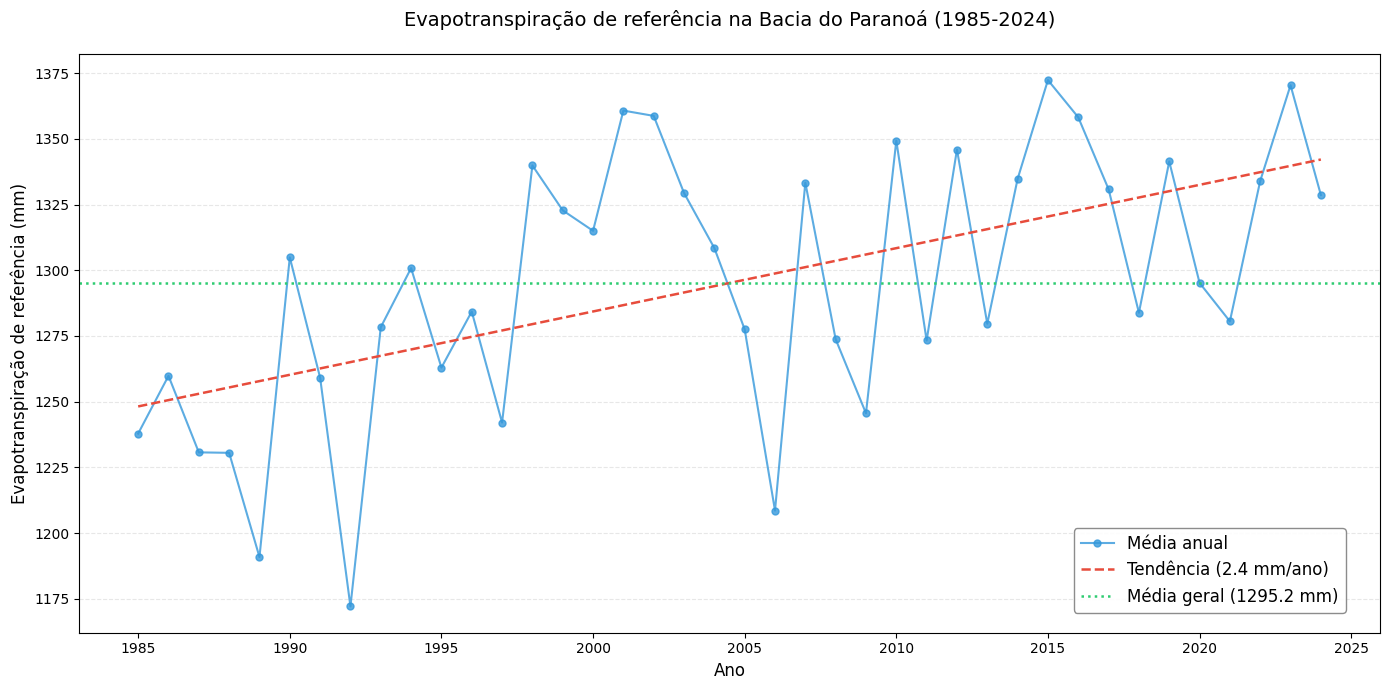

In [12]:
%reload_ext autoreload
plot_medias_bh_lower(resultados, variavel, suffix_name)

## POR UNIDADE HIDROGRÁFICA

In [8]:
resultados = calcular_medias_zonas_paranoa_pet(gdf, anos, zona_column='uh_label')


=== Estatísticas Descritivas ===
| Zona              |   Média Geral (mm) |   CV (%) |   Variação Anual (±mm) | Anos Processados   |
|:------------------|-------------------:|---------:|-----------------------:|:-------------------|
| Córrego Bananal   |            1293.89 |      3.9 |                    7.3 | 40/40              |
| Lago Paranoá      |            1300.83 |      3.9 |                    7.6 | 40/40              |
| Riacho Fundo      |            1299.26 |      3.8 |                    7.9 | 40/40              |
| Ribeirão do Gama  |            1287.33 |      3.8 |                    6.5 | 40/40              |
| Ribeirão do Torto |            1289.47 |      3.9 |                    6.5 | 40/40              |

=== Análise de Tendências ===
| Zona              |   Tendência (mm/ano) |   p-valor |   R² |   Sen's Slope | Mann-Kendall         |
|:------------------|---------------------:|----------:|-----:|--------------:|:---------------------|
| Córrego Bananal   |        

In [9]:
resultados = calcular_medias_zonas_paranoa_temp_pet(gdf, anos, zona_column='uh_label')
tendencias = analise_tendencia_por_zona(resultados)

In [ ]:
#plot_tendencias_zonas_simples(tendencias, "ET0", suffix_name)

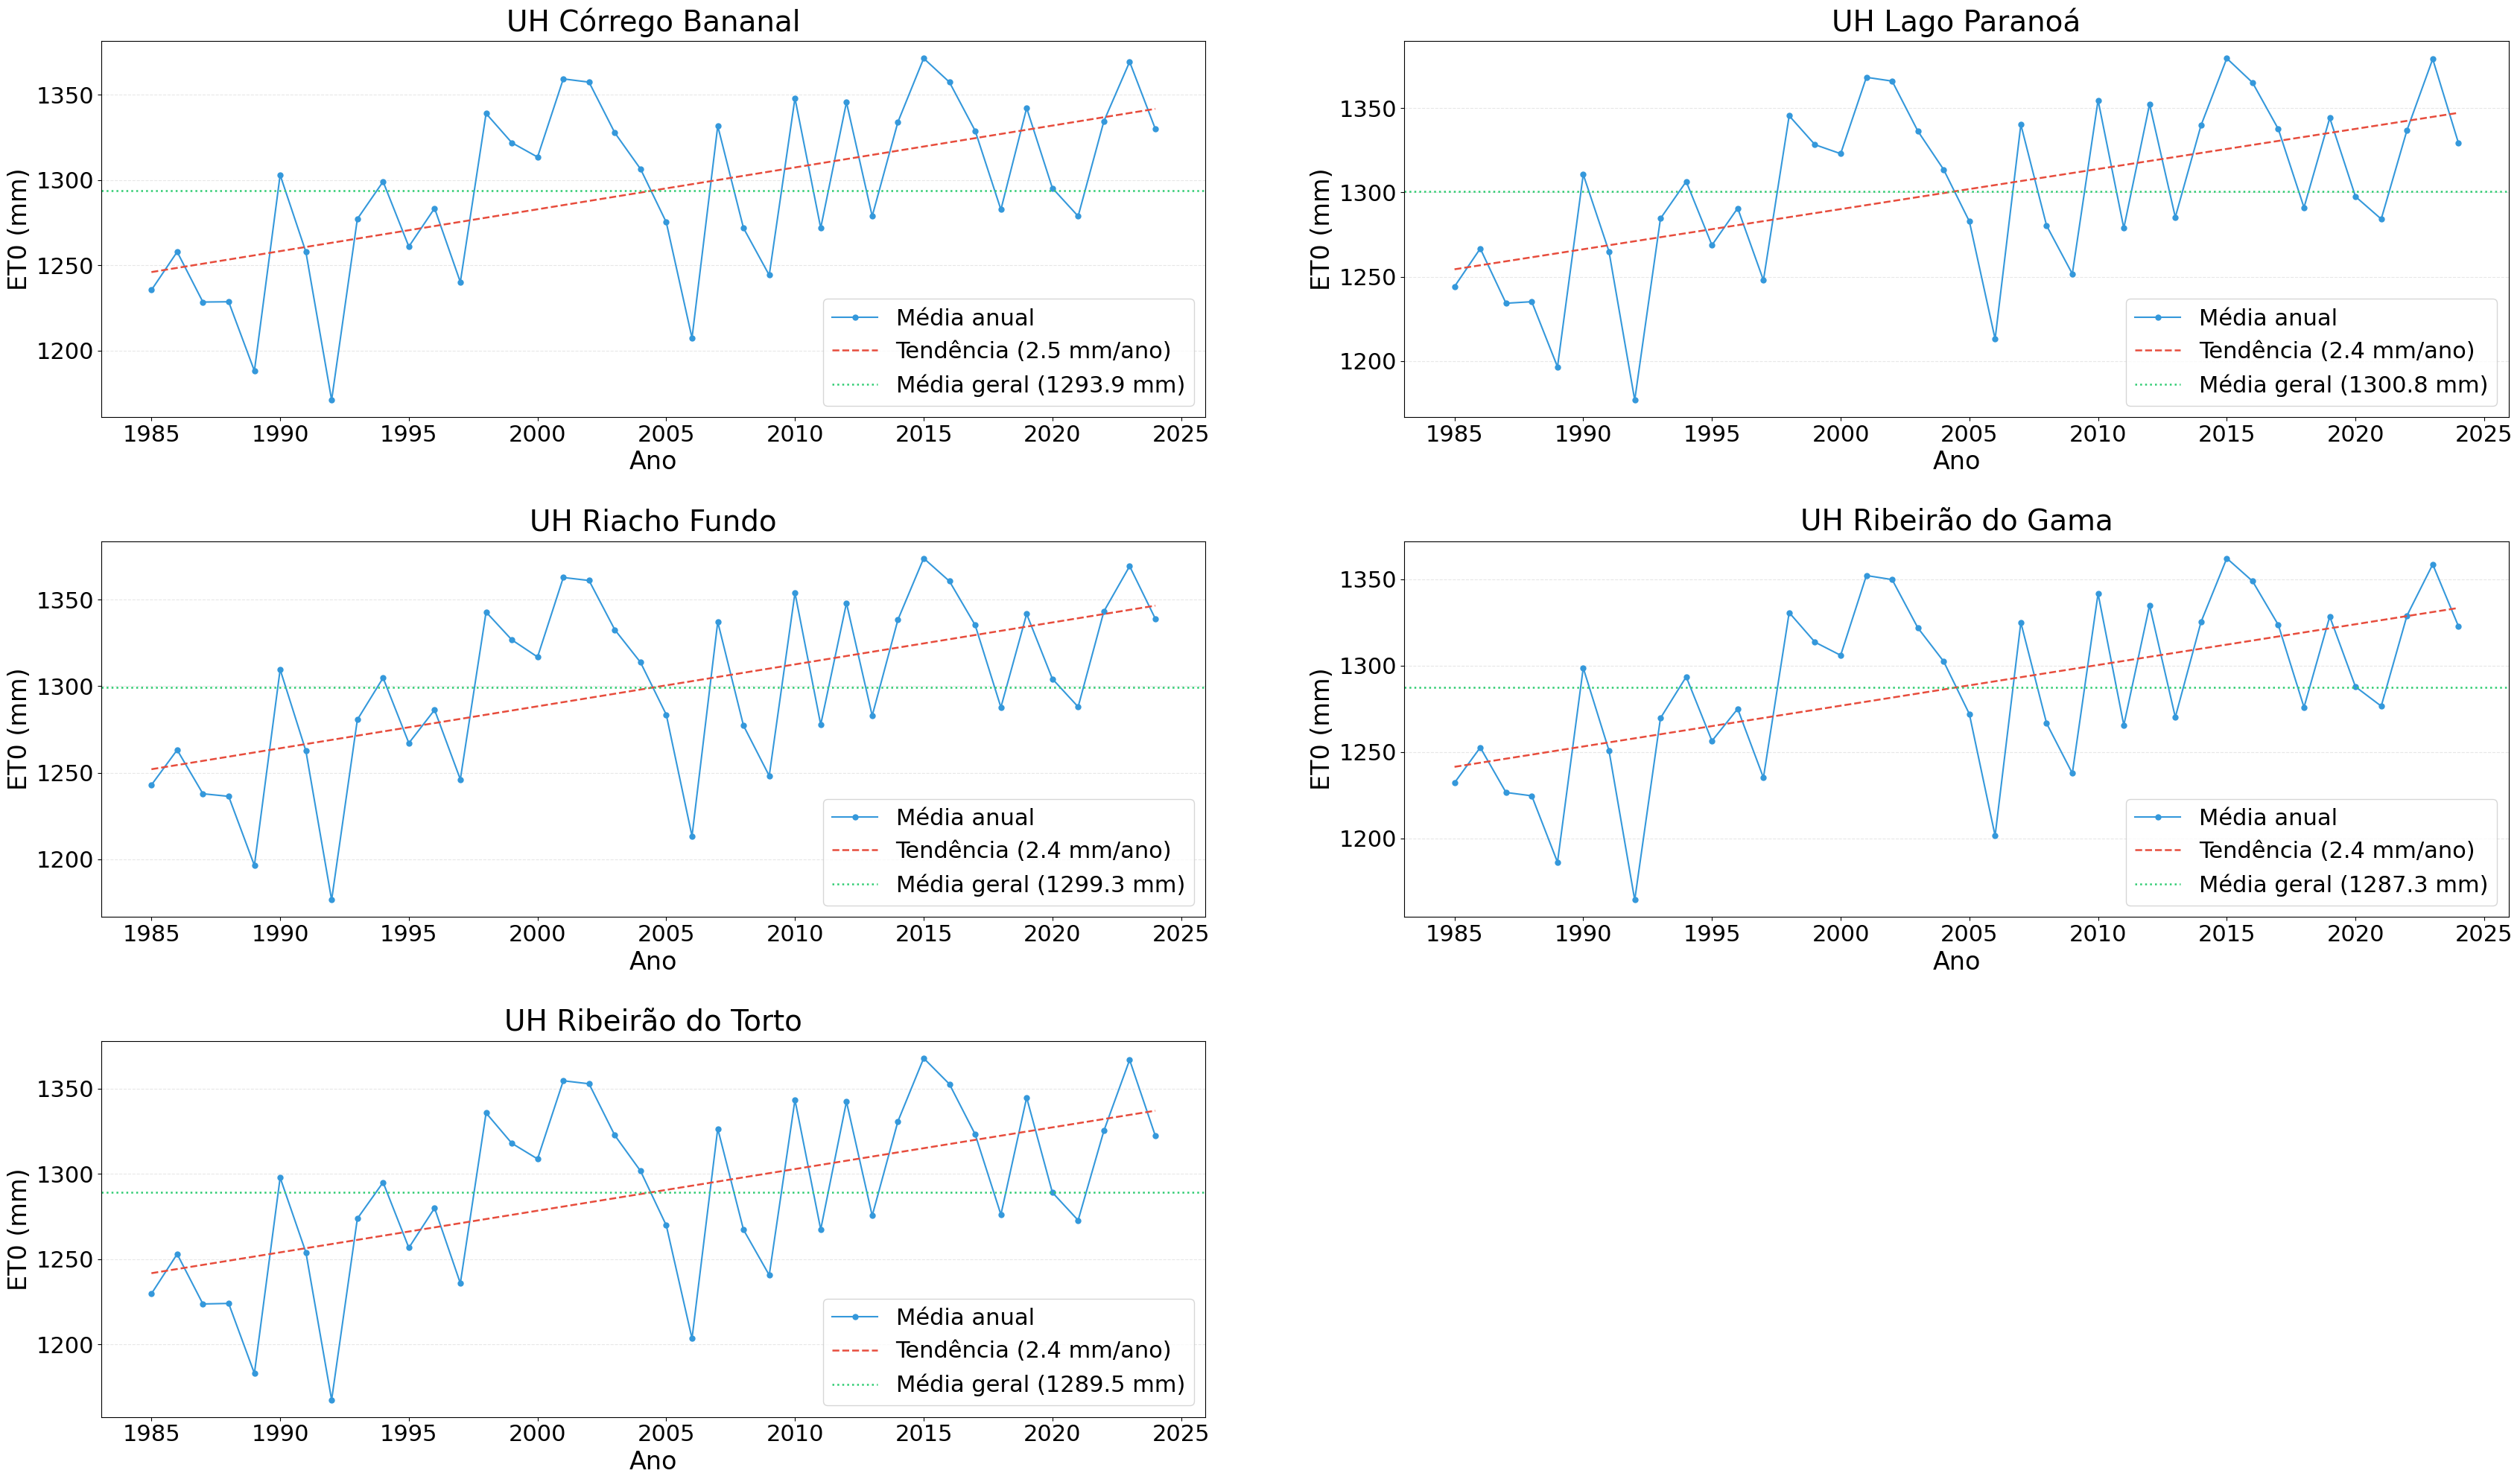

In [10]:
%reload_ext autoreload
plot_tendencias_zonas(tendencias, "ET0", suffix_name)